In [ ]:
# Install dependencies
!pip install tensorflow matplotlib numpy opencv-python


In [ ]:
from pycocotools.coco import COCO
import requests, os, cv2
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras import layers, models, optimizers
import tensorflow as tf


In [ ]:
# Generate small synthetic dataset (3-5 images)
def create_dummy_data(num_images=5, img_size=(128,128)):
    X, y = [], []
    for _ in range(num_images):
        img = np.zeros((*img_size, 3), dtype=np.uint8)
        mask = np.zeros(img_size, dtype=np.uint8)

        # random circle
        center = (random.randint(30, 100), random.randint(30, 100))
        radius = random.randint(10, 30)
        cv2.circle(img, center, radius, (255, 255, 255), -1)
        cv2.circle(mask, center, radius, 255, -1)

        X.append(img / 255.0)
        y.append(mask[..., np.newaxis] / 255.0)
    return np.array(X), np.array(y)

X, y = create_dummy_data(5)
print("Data shape:", X.shape, y.shape)


Data shape: (5, 128, 128, 3) (5, 128, 128, 1)


In [ ]:
def unet_model(input_size=(128,128,3)):
    inputs = layers.Input(input_size)

    # Encoder
    c1 = layers.Conv2D(16, 3, activation='relu', padding='same')(inputs)
    c1 = layers.Conv2D(16, 3, activation='relu', padding='same')(c1)
    p1 = layers.MaxPooling2D()(c1)

    c2 = layers.Conv2D(32, 3, activation='relu', padding='same')(p1)
    c2 = layers.Conv2D(32, 3, activation='relu', padding='same')(c2)
    p2 = layers.MaxPooling2D()(c2)

    # Bottleneck
    b = layers.Conv2D(64, 3, activation='relu', padding='same')(p2)

    # Decoder
    u1 = layers.UpSampling2D()(b)
    concat1 = layers.Concatenate()([u1, c2])
    c3 = layers.Conv2D(32, 3, activation='relu', padding='same')(concat1)

    u2 = layers.UpSampling2D()(c3)
    concat2 = layers.Concatenate()([u2, c1])
    c4 = layers.Conv2D(16, 3, activation='relu', padding='same')(concat2)

    outputs = layers.Conv2D(1, 1, activation='sigmoid')(c4)

    model = models.Model(inputs, outputs)
    return model


In [ ]:
def iou_metric(y_true, y_pred):
    y_pred = tf.round(y_pred)
    intersection = tf.reduce_sum(y_true * y_pred)
    union = tf.reduce_sum(y_true) + tf.reduce_sum(y_pred) - intersection
    return (intersection + 1e-7) / (union + 1e-7)

def dice_coef(y_true, y_pred):
    y_pred = tf.round(y_pred)
    intersection = tf.reduce_sum(y_true * y_pred)
    return (2 * intersection + 1e-7) / (tf.reduce_sum(y_true) + tf.reduce_sum(y_pred) + 1e-7)


In [ ]:
optimizers_list = {
    "SGD": optimizers.SGD(learning_rate=0.001),
    "Adam": optimizers.Adam(learning_rate=0.001),
    "RMSprop": optimizers.RMSprop(learning_rate=0.001)
}

histories = {}

for name, opt in optimizers_list.items():
    print(f"\nTraining with {name} optimizer...")
    model = unet_model()
    model.compile(optimizer=opt, loss='binary_crossentropy', metrics=[iou_metric, dice_coef])
    history = model.fit(X, y, validation_split=0.2, epochs=5, batch_size=1, verbose=1)
    histories[name] = history



Training with SGD optimizer...
Epoch 1/5
4/4 ━━━━━━━━━━━━━━━━━━━━ 4s 325ms/step - dice_coef: 0.0971 - iou_metric: 0.0511 - loss: 0.6946 - val_dice_coef: 0.1157 - val_iou_metric: 0.0614 - val_loss: 0.6939
Epoch 2/5
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 132ms/step - dice_coef: 0.1216 - iou_metric: 0.0648 - loss: 0.6934 - val_dice_coef: 0.1211 - val_iou_metric: 0.0645 - val_loss: 0.6928
Epoch 3/5
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 208ms/step - dice_coef: 0.1309 - iou_metric: 0.0700 - loss: 0.6922 - val_dice_coef: 0.1289 - val_iou_metric: 0.0689 - val_loss: 0.6916
Epoch 4/5
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 212ms/step - dice_coef: 0.1311 - iou_metric: 0.0702 - loss: 0.6911 - val_dice_coef: 0.1345 - val_iou_metric: 0.0721 - val_loss: 0.6904
Epoch 5/5
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 244ms/step - dice_coef: 0.1421 - iou_metric: 0.0765 - loss: 0.6899 - val_dice_coef: 0.1406 - val_iou_metric: 0.0756 - val_loss: 0.6893

Training with Adam optimizer...
Epoch 1/5
4/4 ━━━━━━━━━━━━━━━━━━━━ 5s 260ms/step - dice_coef: 0.4879 -

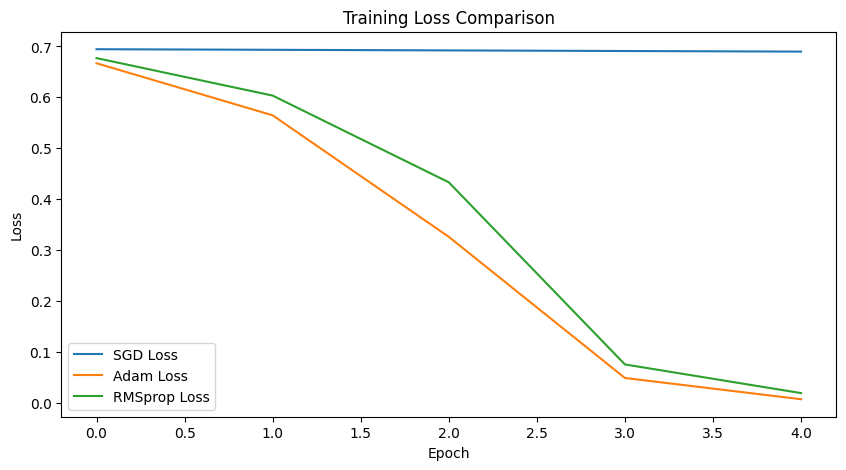

In [ ]:
plt.figure(figsize=(10,5))
for name, hist in histories.items():
    plt.plot(hist.history['loss'], label=f'{name} Loss')
plt.title('Training Loss Comparison')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()


In [ ]:
for name, hist in histories.items():
    iou = hist.history['val_iou_metric'][-1]
    dice = hist.history['val_dice_coef'][-1]
    print(f"{name}: IoU = {iou:.4f}, Dice = {dice:.4f}")


SGD: IoU = 0.0756, Dice = 0.1406
Adam: IoU = 0.9875, Dice = 0.9937
RMSprop: IoU = 0.9806, Dice = 0.9902


In [ ]:
for lr in [0.001, 0.0005, 0.002]:
    print(f"\nTraining with learning rate = {lr}")
    model = unet_model()
    opt = optimizers.Adam(learning_rate=lr)
    model.compile(optimizer=opt, loss='binary_crossentropy', metrics=[iou_metric, dice_coef])
    history = model.fit(X, y, validation_split=0.2, epochs=3, batch_size=1, verbose=1)
    print("Final IoU:", history.history['val_iou_metric'][-1])



Training with learning rate = 0.001
Epoch 1/3
4/4 ━━━━━━━━━━━━━━━━━━━━ 6s 262ms/step - dice_coef: 0.5421 - iou_metric: 0.5118 - loss: 0.6890 - val_dice_coef: 0.9643 - val_iou_metric: 0.9311 - val_loss: 0.6639
Epoch 2/3
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - dice_coef: 0.9380 - iou_metric: 0.8858 - loss: 0.6458 - val_dice_coef: 0.8796 - val_iou_metric: 0.7851 - val_loss: 0.5402
Epoch 3/3
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 126ms/step - dice_coef: 0.8801 - iou_metric: 0.7863 - loss: 0.4684 - val_dice_coef: 0.9226 - val_iou_metric: 0.8563 - val_loss: 0.1751
Final IoU: 0.8562953472137451

Training with learning rate = 0.0005
Epoch 1/3
4/4 ━━━━━━━━━━━━━━━━━━━━ 4s 290ms/step - dice_coef: 0.5180 - iou_metric: 0.4725 - loss: 0.6886 - val_dice_coef: 0.9622 - val_iou_metric: 0.9272 - val_loss: 0.6689
Epoch 2/3
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 160ms/step - dice_coef: 0.9514 - iou_metric: 0.9075 - loss: 0.6607 - val_dice_coef: 0.9343 - val_iou_metric: 0.8767 - val_loss: 0.6212
Epoch 3/3
4/4 ━━━━━━━━━━━━━━━━

In [ ]:
from itertools import product

lrs = [0.001, 0.0005]
bss = [1, 2]

for lr, bs in product(lrs, bss):
    print(f"\nGrid search: lr={lr}, batch_size={bs}")
    model = unet_model()
    opt = optimizers.Adam(learning_rate=lr)
    model.compile(optimizer=opt, loss='binary_crossentropy', metrics=[iou_metric, dice_coef])
    history = model.fit(X, y, validation_split=0.2, epochs=3, batch_size=bs, verbose=1)
    print("Val IoU:", history.history['val_iou_metric'][-1])



Grid search: lr=0.001, batch_size=1
Epoch 1/3
4/4 ━━━━━━━━━━━━━━━━━━━━ 5s 266ms/step - dice_coef: 0.8264 - iou_metric: 0.7247 - loss: 0.6824 - val_dice_coef: 0.9914 - val_iou_metric: 0.9829 - val_loss: 0.6378
Epoch 2/3
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - dice_coef: 0.9850 - iou_metric: 0.9706 - loss: 0.6107 - val_dice_coef: 0.9585 - val_iou_metric: 0.9203 - val_loss: 0.4574
Epoch 3/3
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 134ms/step - dice_coef: 0.9414 - iou_metric: 0.8895 - loss: 0.3853 - val_dice_coef: 0.9843 - val_iou_metric: 0.9692 - val_loss: 0.0881
Val IoU: 0.9691803455352783

Grid search: lr=0.001, batch_size=2
Epoch 1/3
2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 691ms/step - dice_coef: 0.4220 - iou_metric: 0.3524 - loss: 0.6873 - val_dice_coef: 0.9284 - val_iou_metric: 0.8664 - val_loss: 0.6593
Epoch 2/3
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 270ms/step - dice_coef: 0.9217 - iou_metric: 0.8550 - loss: 0.6560 - val_dice_coef: 0.9452 - val_iou_metric: 0.8960 - val_loss: 0.6250
Epoch 3/3
2/2 ━━━━━━━━━━━━━━━━━━━

In [ ]:
import random

param_space = {
    "lr": [0.001, 0.0005, 0.002],
    "batch_size": [1, 2],
    "optimizer": ["Adam", "RMSprop", "SGD"]
}

for i in range(5):
    lr = random.choice(param_space["lr"])
    bs = random.choice(param_space["batch_size"])
    opt_name = random.choice(param_space["optimizer"])

    if opt_name == "Adam":
        opt = optimizers.Adam(learning_rate=lr)
    elif opt_name == "RMSprop":
        opt = optimizers.RMSprop(learning_rate=lr)
    else:
        opt = optimizers.SGD(learning_rate=lr)

    print(f"\nRandom search #{i+1}: {opt_name}, lr={lr}, bs={bs}")
    model = unet_model()
    model.compile(optimizer=opt, loss='binary_crossentropy', metrics=[iou_metric, dice_coef])
    history = model.fit(X, y, validation_split=0.2, epochs=3, batch_size=bs, verbose=1)
    print("Validation IoU:", history.history['val_iou_metric'][-1])



Random search #1: Adam, lr=0.002, bs=1
Epoch 1/3
4/4 ━━━━━━━━━━━━━━━━━━━━ 5s 259ms/step - dice_coef: 0.6654 - iou_metric: 0.5332 - loss: 0.6696 - val_dice_coef: 0.9882 - val_iou_metric: 0.9767 - val_loss: 0.5427
Epoch 2/3
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - dice_coef: 0.9538 - iou_metric: 0.9187 - loss: 0.4530 - val_dice_coef: 0.9914 - val_iou_metric: 0.9830 - val_loss: 0.0840
Epoch 3/3
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step - dice_coef: 0.9765 - iou_metric: 0.9547 - loss: 0.0605 - val_dice_coef: 0.9678 - val_iou_metric: 0.9376 - val_loss: 0.0178
Validation IoU: 0.9375772476196289

Random search #2: Adam, lr=0.002, bs=1
Epoch 1/3
4/4 ━━━━━━━━━━━━━━━━━━━━ 5s 257ms/step - dice_coef: 0.8564 - iou_metric: 0.7576 - loss: 0.6654 - val_dice_coef: 0.9802 - val_iou_metric: 0.9612 - val_loss: 0.5362
Epoch 2/3
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 122ms/step - dice_coef: 0.9705 - iou_metric: 0.9430 - loss: 0.4665 - val_dice_coef: 0.9627 - val_iou_metric: 0.9281 - val_loss: 0.0868
Epoch 3/3
4/4 ━━━━━━

In [ ]:
# COCO 2017 validation annotations (small JSON)
annFile = "http://images.cocodataset.org/annotations/annotations_trainval2017.zip"
!wget -q http://images.cocodataset.org/annotations/annotations_trainval2017.zip -O coco_annotations.zip
!unzip -q coco_annotations.zip -d coco_annotations


In [ ]:
annFile = 'coco_annotations/annotations/instances_val2017.json'
coco = COCO(annFile)


loading annotations into memory...
Done (t=1.03s)
creating index...
index created!


In [ ]:
# Choose one category (change this if you want)
catIds = coco.getCatIds(catNms=['person'])
imgIds = coco.getImgIds(catIds=catIds)
print(f"Total images with 'person': {len(imgIds)}")

# Select first 5 images only
selected_imgs = imgIds[:5]

os.makedirs("coco_small/images", exist_ok=True)
os.makedirs("coco_small/masks", exist_ok=True)

X, y = [], []

for img_id in selected_imgs:
    img_info = coco.loadImgs(img_id)[0]
    img_url = img_info['coco_url']

    # Download image
    img = cv2.imdecode(np.frombuffer(requests.get(img_url).content, np.uint8), cv2.IMREAD_COLOR)
    img = cv2.resize(img, (128,128))

    # Get annotation IDs for this image
    ann_ids = coco.getAnnIds(imgIds=img_id, catIds=catIds, iscrowd=False)
    anns = coco.loadAnns(ann_ids)

    # Create blank mask
    mask = np.zeros((img.shape[0], img.shape[1]), dtype=np.uint8)

    # Draw all segmentations for selected category
    for ann in anns:
        m = coco.annToMask(ann)
        m = cv2.resize(m, (128,128))
        mask = np.maximum(mask, m)

    # Normalize and store
    X.append(img / 255.0)
    y.append(mask[..., np.newaxis])

X = np.array(X)
y = np.array(y)
print("Dataset shapes:", X.shape, y.shape)


Total images with 'person': 2693
Dataset shapes: (5, 128, 128, 3) (5, 128, 128, 1)


In [ ]:
def unet_model(input_size=(128,128,3)):
    inputs = layers.Input(input_size)

    c1 = layers.Conv2D(16, 3, activation='relu', padding='same')(inputs)
    c1 = layers.Conv2D(16, 3, activation='relu', padding='same')(c1)
    p1 = layers.MaxPooling2D()(c1)

    c2 = layers.Conv2D(32, 3, activation='relu', padding='same')(p1)
    c2 = layers.Conv2D(32, 3, activation='relu', padding='same')(c2)
    p2 = layers.MaxPooling2D()(c2)

    b = layers.Conv2D(64, 3, activation='relu', padding='same')(p2)

    u1 = layers.UpSampling2D()(b)
    concat1 = layers.Concatenate()([u1, c2])
    c3 = layers.Conv2D(32, 3, activation='relu', padding='same')(concat1)

    u2 = layers.UpSampling2D()(c3)
    concat2 = layers.Concatenate()([u2, c1])
    c4 = layers.Conv2D(16, 3, activation='relu', padding='same')(concat2)

    outputs = layers.Conv2D(1, 1, activation='sigmoid')(c4)

    model = models.Model(inputs, outputs)
    return model


In [ ]:
y = y.astype('float32')


In [ ]:
def iou_metric(y_true, y_pred):
    y_pred = tf.round(y_pred)
    intersection = tf.reduce_sum(y_true * y_pred)
    union = tf.reduce_sum(y_true) + tf.reduce_sum(y_pred) - intersection
    return (intersection + 1e-7) / (union + 1e-7)

def dice_coef(y_true, y_pred):
    y_pred = tf.round(y_pred)
    intersection = tf.reduce_sum(y_true * y_pred)
    return (2 * intersection + 1e-7) / (tf.reduce_sum(y_true) + tf.reduce_sum(y_pred) + 1e-7)

model = unet_model()
model.compile(optimizer=optimizers.Adam(learning_rate=0.001),
              loss='binary_crossentropy',
              metrics=[iou_metric, dice_coef])

history = model.fit(X, y, validation_split=0.2, epochs=5, batch_size=1)


Epoch 1/5
4/4 ━━━━━━━━━━━━━━━━━━━━ 5s 359ms/step - dice_coef: 0.1011 - iou_metric: 0.0567 - loss: 0.6343 - val_dice_coef: 4.7619e-10 - val_iou_metric: 4.7619e-10 - val_loss: 0.3631
Epoch 2/5
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 238ms/step - dice_coef: 2.2853e-10 - iou_metric: 2.2853e-10 - loss: 0.4597 - val_dice_coef: 4.7619e-10 - val_iou_metric: 4.7619e-10 - val_loss: 0.0767
Epoch 3/5
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 256ms/step - dice_coef: 1.9842e-10 - iou_metric: 1.9842e-10 - loss: 0.4672 - val_dice_coef: 4.7619e-10 - val_iou_metric: 4.7619e-10 - val_loss: 0.0992
Epoch 4/5
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 138ms/step - dice_coef: 2.2853e-10 - iou_metric: 2.2853e-10 - loss: 1.3034 - val_dice_coef: 4.7619e-10 - val_iou_metric: 4.7619e-10 - val_loss: 0.0877
Epoch 5/5
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 128ms/step - dice_coef: 1.2548e-10 - iou_metric: 1.2548e-10 - loss: 0.6385 - val_dice_coef: 4.7619e-10 - val_iou_metric: 4.7619e-10 - val_loss: 0.2093


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 931ms/step


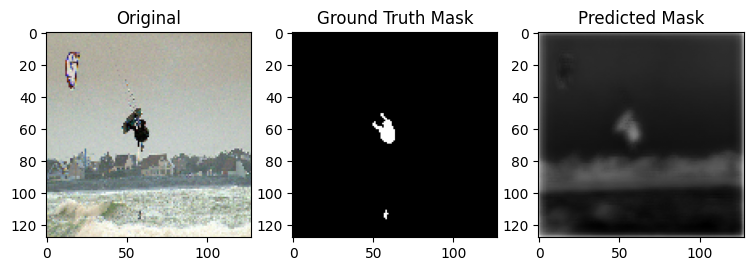

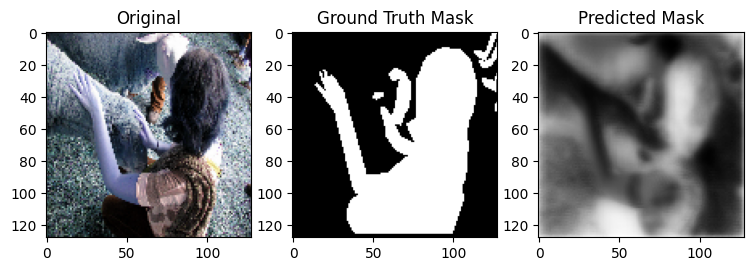

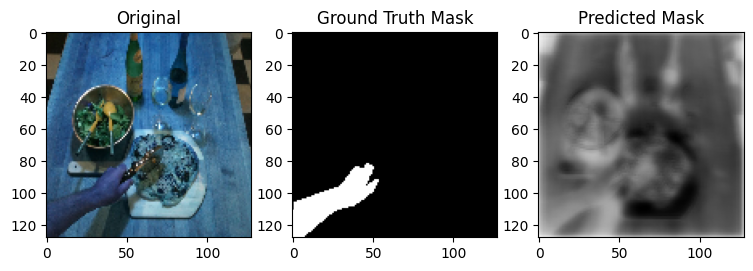

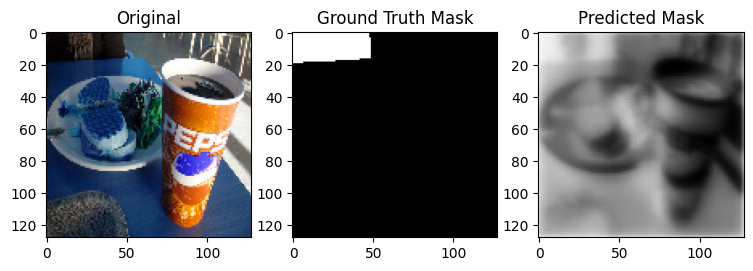

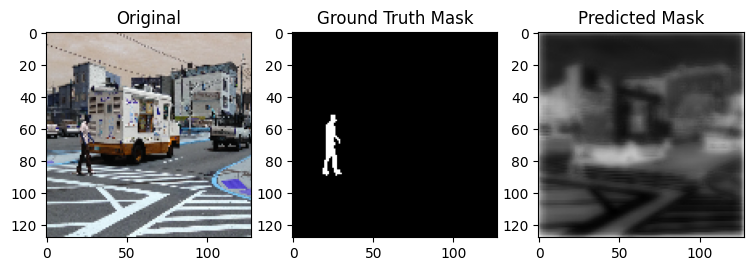

In [ ]:
preds = model.predict(X)

for i in range(len(X)):
    plt.figure(figsize=(9,3))
    plt.subplot(1,3,1)
    plt.imshow(X[i])
    plt.title("Original")

    plt.subplot(1,3,2)
    plt.imshow(y[i].squeeze(), cmap='gray')
    plt.title("Ground Truth Mask")

    plt.subplot(1,3,3)
    plt.imshow(preds[i].squeeze(), cmap='gray')
    plt.title("Predicted Mask")
    plt.show()
